## EDA analysis for *Anonymized Implementation Tickets Dataset (anonymized_hubspot_tickets.csv)*

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# load data
path = "/Users/annalorenz/Documents/Uni/Vanderbilt/02_Courses/spring2025/Machine_learning/project/data/anonymized_hubspot_tickets.csv"
df = pd.read_csv(path)

## Step 1: Data Cleaning 

In [23]:
print("\n Dataset Overview:")
print(df.info())


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 46 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Create date                                    79 non-null     object 
 1   Ticket Tags                                    0 non-null      float64
 2   Stage Date - Project Launch                    31 non-null     object 
 3   Associated Contact                             78 non-null     object 
 4   Category                                       0 non-null      float64
 5   Target Launch Date                             29 non-null     object 
 6   Kickoff Call                                   49 non-null     object 
 7   Close date                                     55 non-null     object 
 8   Pipeline                                       79 non-null     object 
 9   Stage Date - Project Initiation     

In [24]:
df.columns

Index(['Create date', 'Ticket Tags', 'Stage Date - Project Launch',
       'Associated Contact', 'Category', 'Target Launch Date', 'Kickoff Call',
       'Close date', 'Pipeline', 'Stage Date - Project Initiation',
       'Stage Date - Planning Phase', 'Ticket status',
       'Stage Date - Execution', 'Time to first agent email reply (HH:mm:ss)',
       'Last CES survey rating', 'Priority', 'Associated Company',
       'Who will be creating the Syms?', 'Stage Date - Closure Phase',
       'Stage Date - Monitoring and Control Phase',
       'Associated Company (Primary)', 'Response time (HH:mm:ss)', 'Ticket ID',
       'Time to close (HH:mm:ss)', 'Associated Deal', 'Library index approved',
       'Training: General Overview', 'Latest Milestone',
       'Training: Deployment/User Management Training',
       'Requirements for the Trial', 'Training: Sym Building 101',
       'Last modified date', 'Type', 'Trial End Date',
       'Training: Sym Building 201', 'Stage Date - Converted Won',

### This block performs data cleaning by removing columns with over 80% missing or zero values. It then fills missing values using the mode for categorical features and the median for numeric ones


In [25]:
# Remove columns with more than 80% missing data or 0 entries 
threshold = 0.8
df_cleaned = df.loc[:, df.isnull().mean() < threshold].copy()

zero_threshold = 0.8
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
cols_to_drop = [col for col in num_columns if (df[col] == 0).mean() > zero_threshold]
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

num_columns = df_cleaned.select_dtypes(include=[np.number]).columns

cat_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    mode_value = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(mode_value)

for col in num_columns:
    median_value = df[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

print("DataFrame shape after cleaning:", df_cleaned.shape)
print(df_cleaned.info())

DataFrame shape after cleaning: (79, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Create date                                    79 non-null     object
 1   Stage Date - Project Launch                    79 non-null     object
 2   Associated Contact                             79 non-null     object
 3   Target Launch Date                             79 non-null     object
 4   Kickoff Call                                   79 non-null     object
 5   Close date                                     79 non-null     object
 6   Pipeline                                       79 non-null     object
 7   Stage Date - Project Initiation                79 non-null     object
 8   Ticket status                                  79 non-null     object
 9   Stage Date - Execution    

### This step converts date columns to the datetime format 

In [26]:
# Convert date columns to datetime format
date_cols = ['Create date', 
             'Stage Date - Project Launch', 
             'Target Launch Date', 
             'Kickoff Call', 
             'Close date', 
             'Stage Date - Project Initiation', 
             'Stage Date - Execution', 
             'Stage Date - Closure Phase', 
             'Stage Date - Converted Won', 
             'Latest Milestone Update Date', 
             'Training: Deployment/User Management Training',
             'Training: Sym Building 101',
             'Training: Sym Building 201',
             'Training: General Overview',
             'Trial Start Date', 
             'Trial End Date',
             '1st Syms presented for review', 
             'Project Launch Day', 
             'Training: Reporting', 
             'Construction of 1st Sym begun', 
             'Last modified date']
for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')


In [27]:
# Convert time variables to numeric
time_cols = ['Time to first agent email reply (HH:mm:ss)', 'Time to close (HH:mm:ss)', 'Response time (HH:mm:ss)']

for col in time_cols:
    df_cleaned[col] = pd.to_timedelta(df_cleaned[col], errors='coerce')


### This step creates a new feature duration by calculating the number of days between Create Date and Last Modified Date

In [28]:
# Feature Engineering
# Implementation_duration_days: days from creating to closure 
df_cleaned['implementation_duration_days'] = (df_cleaned['Close date'] - df_cleaned['Create date']).dt.days

print(df_cleaned[df_cleaned['implementation_duration_days'] < 0][['Create date', 'Close date', 'implementation_duration_days', 'Time to close (HH:mm:ss)']])
df_cleaned = df_cleaned[df_cleaned['implementation_duration_days'] >= 0] # Remove rows with negative implementation duration as they are potentially erroneous

avg_duration = df_cleaned['implementation_duration_days'].mean() 
avg_close_duration = df_cleaned['Time to close (HH:mm:ss)'].mean() 

# Days_to_first_sym: days to first simulation delivery 
df_cleaned['days_to_first_sym'] = (df_cleaned['1st Syms presented for review'] - df_cleaned['Create date']).dt.days


# Implementation_status: simplified status categories 
df_cleaned['implementation_status'] = df_cleaned['Ticket status'].map({"Converted-Won": "Won", "Lost": "Lost", "Project Launch": "In Progress", "Planning Phase": "In Progress", "Execution Phase": "In Progress",
                                                                        "Closure Phase": "In Progress", "Monitoring and Control Phase": "In Progress", "Project Initiation Phase": "In Progress"     
                                                                      })
 
# Create_Year: year when the ticket was created 
df_cleaned['create_year'] = df_cleaned['Create date'].dt.year

# Create_Month: month when the ticket was created
df_cleaned['create_month'] = df_cleaned['Create date'].dt.month

# Create_YearMonth: year-month for time-based analysis 
df_cleaned['create_YearMonth'] = df_cleaned['Create date'].dt.to_period('M')


           Create date          Close date  implementation_duration_days  \
2  2024-12-12 09:01:00 2024-04-30 10:56:00                          -226   
4  2025-02-14 13:34:00 2024-04-30 10:56:00                          -291   
11 2025-01-07 09:56:00 2024-04-30 10:56:00                          -252   
12 2024-10-25 16:23:00 2024-04-30 10:56:00                          -179   
13 2024-12-20 09:16:00 2024-04-30 10:56:00                          -234   
18 2024-11-11 10:03:00 2024-04-30 10:56:00                          -195   
30 2024-06-11 19:18:00 2024-04-30 10:56:00                           -43   
31 2025-01-07 09:54:00 2024-04-30 10:56:00                          -252   
34 2025-01-07 16:06:00 2024-04-30 10:56:00                          -253   
37 2024-10-28 16:53:00 2024-04-30 10:56:00                          -182   
38 2024-05-21 11:22:00 2024-04-30 10:56:00                           -22   
59 2025-01-08 14:26:00 2024-04-30 10:56:00                          -254   
61 2025-01-2

In [29]:
avg_duration

112.16071428571429

In [30]:
avg_close_duration

Timedelta('112 days 05:41:12.267857142')

In [31]:
df_cleaned[['create_year'] + ['create_month', 'create_YearMonth']].head()

,create_year,create_month,create_YearMonth
0,2023,12,2023-12
1,2024,10,2024-10
3,2023,9,2023-09
5,2024,7,2024-07
6,2024,7,2024-07


In [32]:
# Convert Ticket ID to categorical variable
df_cleaned['Ticket ID'] = df_cleaned['Ticket ID'].astype('category')
num_tickets = df_cleaned['Ticket ID'].nunique()
print(num_tickets)

num_companies = df_cleaned['Associated Company'].nunique()
print(num_companies)

56
39


### This step handles outliers in numeric columns by applying the IQR method and capping extreme values at the lower and upper bounds

In [33]:
print(df_cleaned.isnull().sum())

Create date                                      0
Stage Date - Project Launch                      0
Associated Contact                               0
Target Launch Date                               0
Kickoff Call                                     0
Close date                                       0
Pipeline                                         0
Stage Date - Project Initiation                  0
Ticket status                                    0
Stage Date - Execution                           0
Time to first agent email reply (HH:mm:ss)       0
Associated Company                               0
Stage Date - Closure Phase                       0
Associated Company (Primary)                     0
Response time (HH:mm:ss)                         0
Ticket ID                                        0
Time to close (HH:mm:ss)                         0
Associated Deal                                  0
Library index approved                           0
Training: General Overview     

In [34]:
# Missing values
missing_values = df_cleaned.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df_cleaned)) * 100
df_missing = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
display(df_missing[df_missing['Missing Values'] > 0])

,Missing Values,Percentage


In [35]:
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
time_like_columns = df_cleaned.select_dtypes(include=['timedelta64[ns]', 'datetime64[ns]']).columns
num_columns = [col for col in num_columns if col not in time_like_columns]

# Outlier Handling
for col in num_columns:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

print(df_cleaned.shape)
print(df_cleaned.columns)

(56, 42)
Index(['Create date', 'Stage Date - Project Launch', 'Associated Contact',
       'Target Launch Date', 'Kickoff Call', 'Close date', 'Pipeline',
       'Stage Date - Project Initiation', 'Ticket status',
       'Stage Date - Execution', 'Time to first agent email reply (HH:mm:ss)',
       'Associated Company', 'Stage Date - Closure Phase',
       'Associated Company (Primary)', 'Response time (HH:mm:ss)', 'Ticket ID',
       'Time to close (HH:mm:ss)', 'Associated Deal', 'Library index approved',
       'Training: General Overview', 'Latest Milestone',
       'Training: Deployment/User Management Training',
       'Requirements for the Trial', 'Training: Sym Building 101',
       'Last modified date', 'Trial End Date', 'Training: Sym Building 201',
       'Stage Date - Converted Won', 'Latest Milestone Update Date',
       'Ticket name', 'Trial Overview', 'Trial Start Date',
       '1st Syms presented for review', 'Project Launch Day',
       'Training: Reporting', 'Construct

## Step 2: Exploratory Data Analysis (EDA) 

### Class distribution

In [36]:
for col in cat_columns:
    print(f"\nValue counts for '{col}':")
    print(df_cleaned[col].value_counts())


Value counts for 'Create date':
Create date
2023-12-18 15:02:00    1
2024-10-30 12:31:00    1
2023-09-26 18:05:00    1
2024-12-20 11:00:00    1
2024-12-20 10:58:00    1
2024-11-22 09:41:00    1
2024-08-28 09:12:00    1
2024-06-21 11:26:00    1
2024-04-01 09:23:00    1
2023-11-09 14:30:00    1
2024-07-19 16:38:00    1
2024-04-01 19:36:00    1
2024-02-15 14:03:00    1
2024-04-01 19:52:00    1
2024-04-01 19:45:00    1
2024-04-01 09:17:00    1
2024-04-03 08:25:00    1
2024-04-03 08:24:00    1
2024-01-02 09:21:00    1
2023-11-28 09:36:00    1
2024-08-13 13:26:00    1
2024-07-19 16:51:00    1
2024-05-20 17:00:00    1
2024-04-02 10:16:00    1
2023-09-12 10:59:00    1
2023-11-06 08:15:00    1
2023-08-01 15:22:00    1
2023-06-01 15:20:00    1
2023-07-01 15:19:00    1
2023-08-01 15:17:00    1
2024-05-22 11:03:00    1
2023-09-07 16:37:00    1
2024-07-31 10:27:00    1
2024-07-31 10:28:00    1
2024-09-10 09:29:00    1
2023-08-28 15:52:00    1
2023-12-05 13:02:00    1
2024-04-03 07:42:00    1
2025-

### Summary Statistics

In [37]:
display(df_cleaned.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Create date,56,NaN,NaN,NaN,2024-03-23 17:50:25.714285312,2023-06-01 15:14:00,2023-11-08 19:20:00,2024-04-02 23:17:00,2024-07-21 09:43:00,2025-02-06 09:00:00,NaN
Stage Date - Project Launch,56,NaN,NaN,NaN,2024-02-20 09:25:42.857142784,2023-12-08 00:00:00,2023-12-14 00:00:00,2023-12-14 00:00:00,2024-04-21 06:00:00,2024-10-15 00:00:00,NaN
Associated Contact,56,53,Contact_a4562b7d,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Target Launch Date,56,NaN,NaN,NaN,2023-11-01 16:42:51.428571392,2023-09-02 00:00:00,2023-09-08 00:00:00,2023-09-08 00:00:00,2023-12-02 00:00:00,2024-06-03 00:00:00,NaN
Kickoff Call,56,NaN,NaN,NaN,2024-04-19 23:08:34.285714176,2023-01-11 00:00:00,2023-11-25 06:00:00,2024-07-20 00:00:00,2024-08-13 00:00:00,2024-12-09 00:00:00,NaN
Close date,56,NaN,NaN,NaN,2024-07-14 11:19:26.785714176,2023-10-24 10:51:00,2024-03-19 10:12:00,2024-06-26 10:22:30,2024-11-19 08:36:00,2025-02-12 15:20:00,NaN
Pipeline,56,1,Project Success Plan,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stage Date - Project Initiation,56,NaN,NaN,NaN,2024-05-11 00:00:00,2023-12-05 00:00:00,2024-04-01 00:00:00,2024-04-01 00:00:00,2024-05-26 12:00:00,2025-02-06 00:00:00,NaN
Ticket status,56,4,Converted-Won,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stage Date - Execution,56,NaN,NaN,NaN,2024-07-07 23:34:17.142857216,2023-12-05 00:00:00,2024-07-19 00:00:00,2024-07-19 00:00:00,2024-07-19 00:00:00,2024-12-20 00:00:00,NaN


### Feature correlations for numeric variables

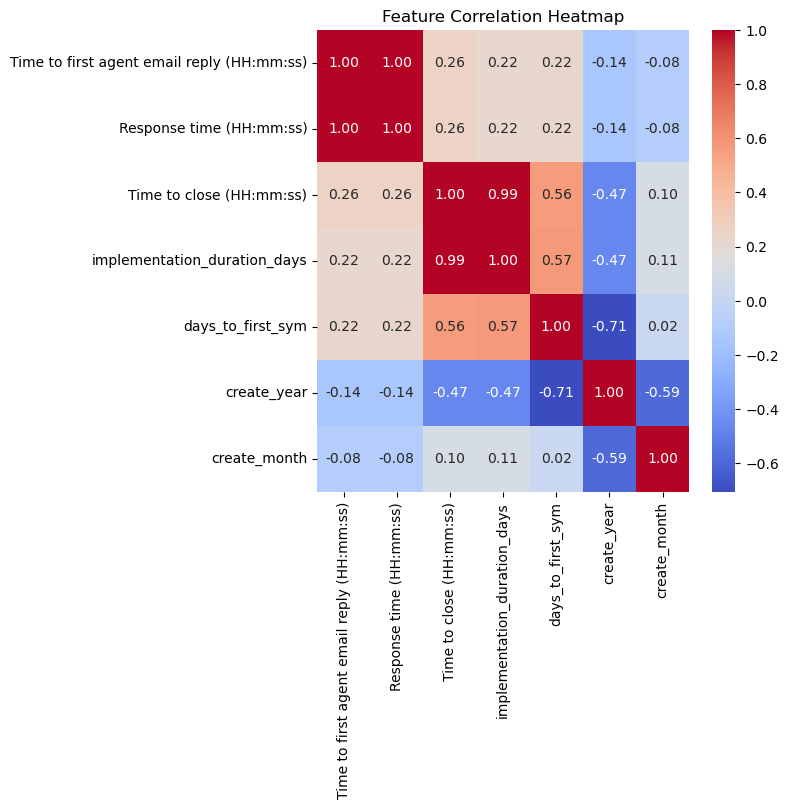

In [38]:
# Feature correlation heatmap (not very meaningful because no numerical variables)
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(6,6))
sns.heatmap(df_cleaned[num_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

This dataset does not contain numerical variables other than time variables and created variables. There the correlation heatmap should be interpreted with caution. 

### Data visualizations 

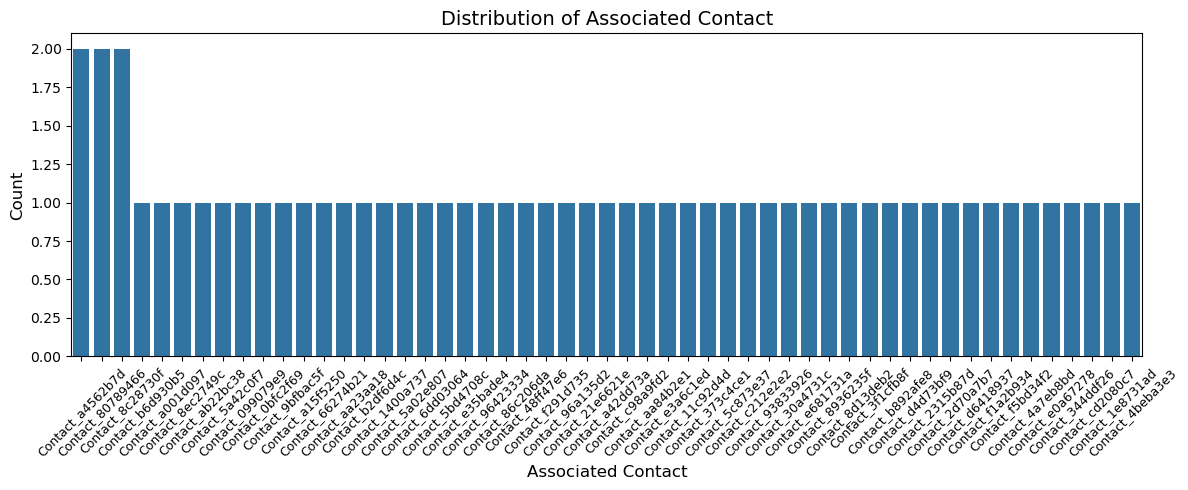

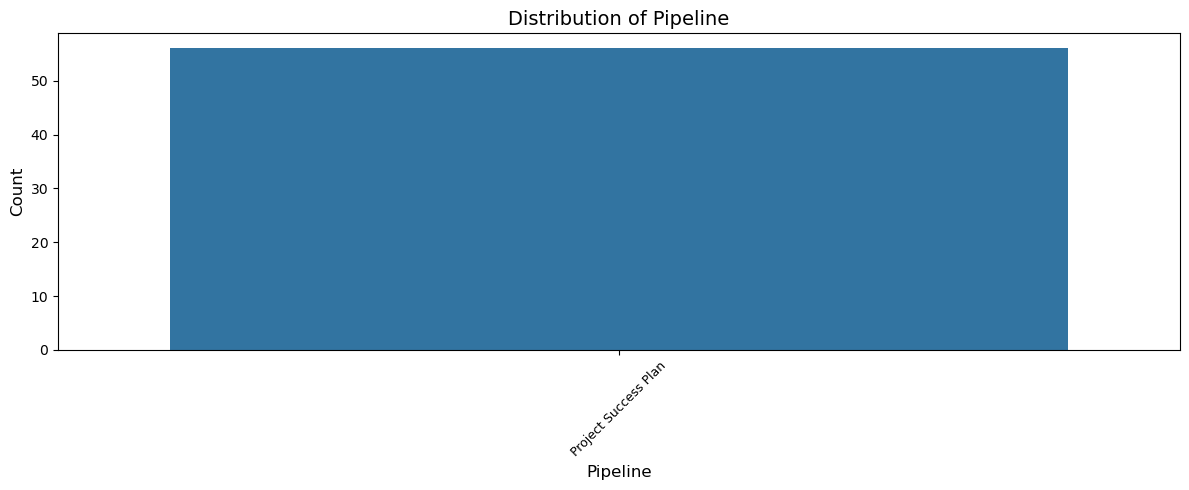

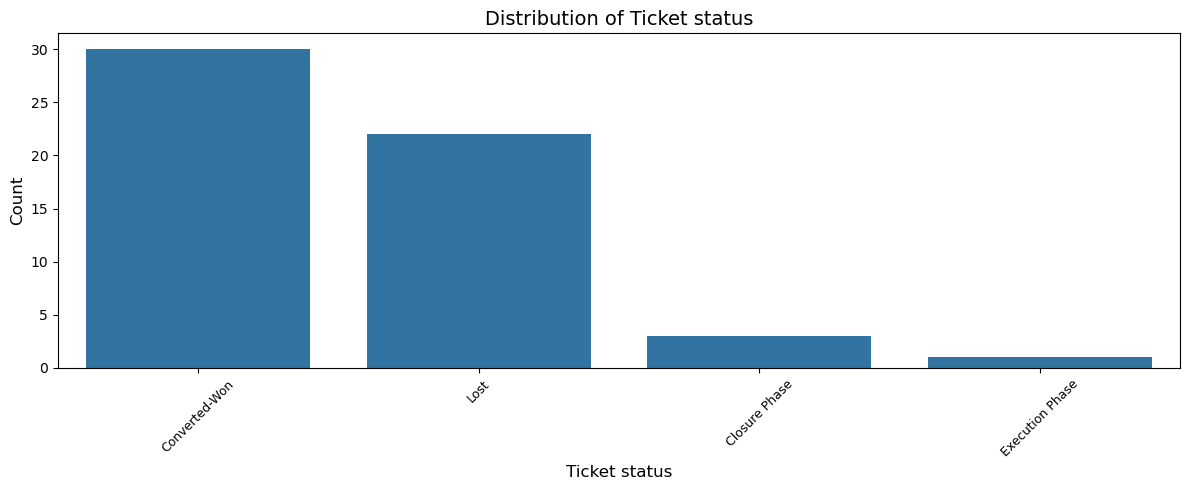

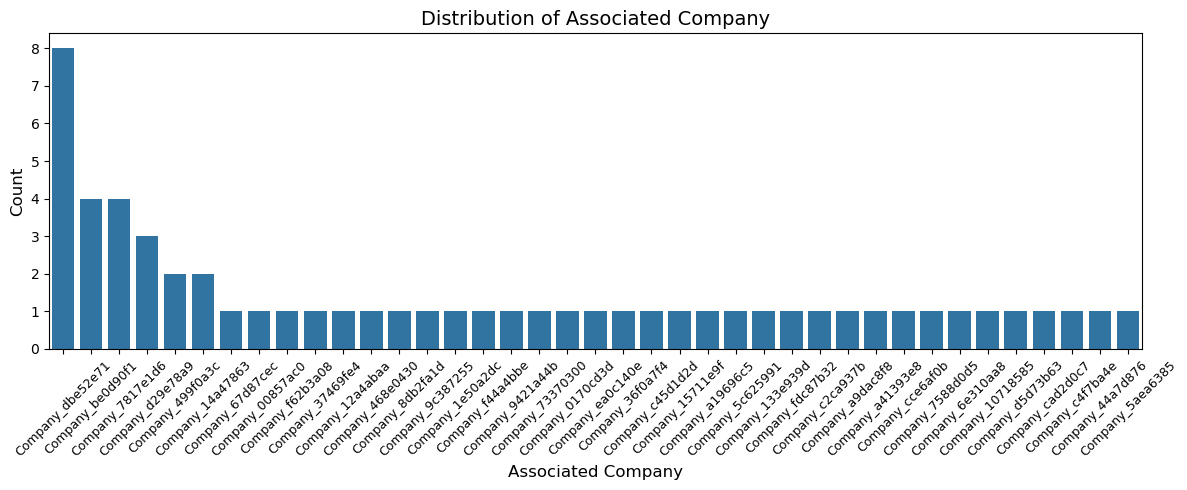

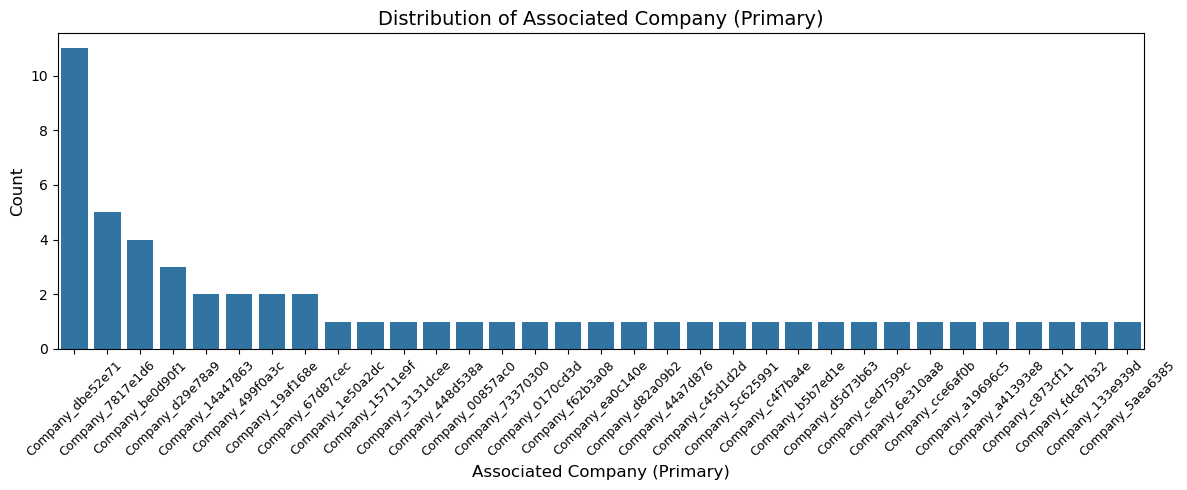

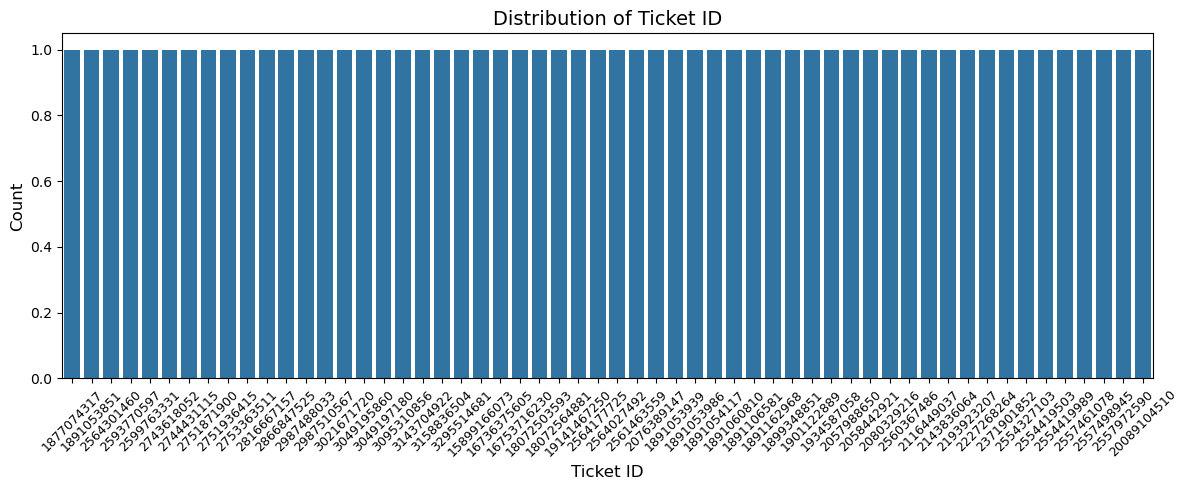

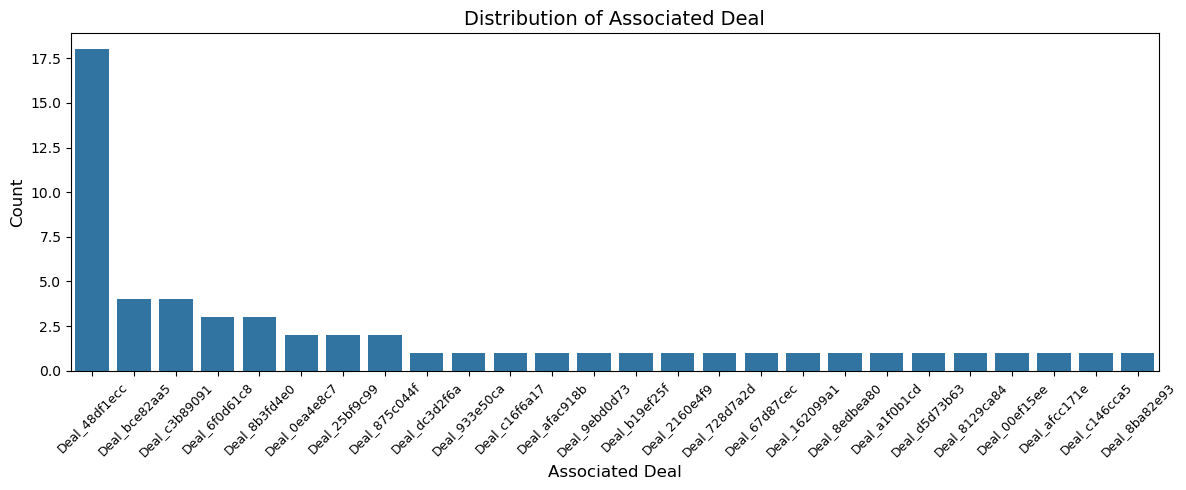

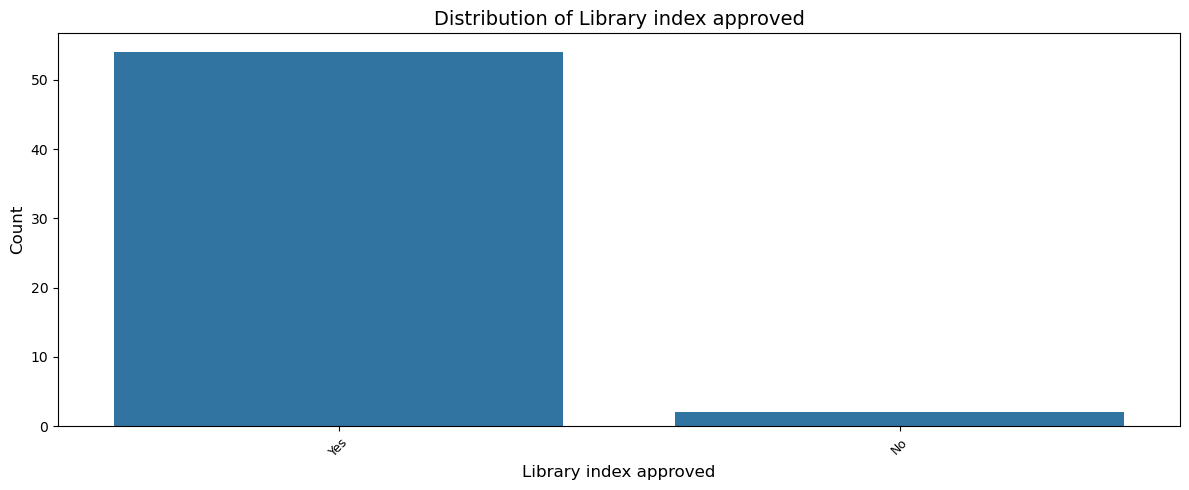

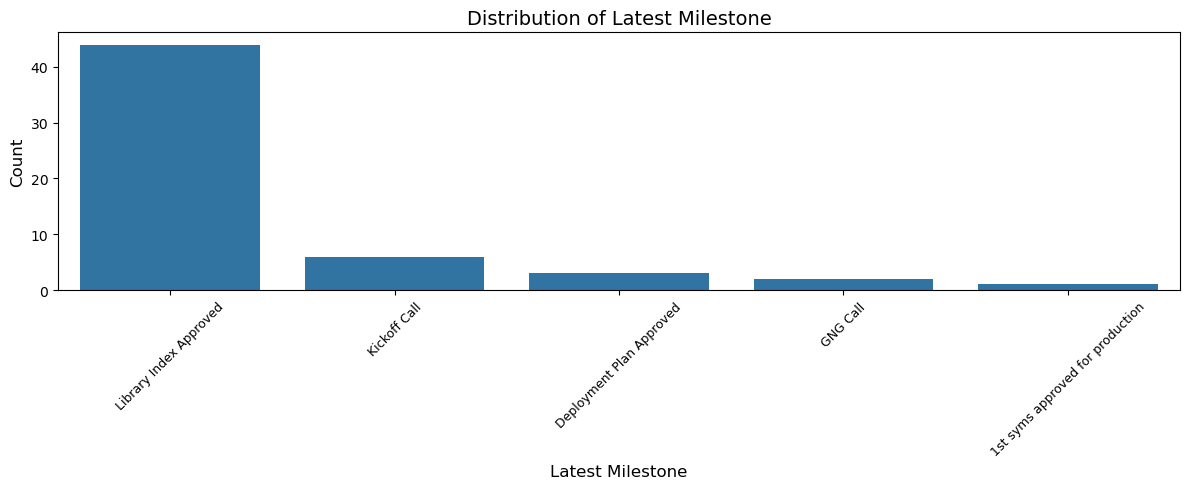

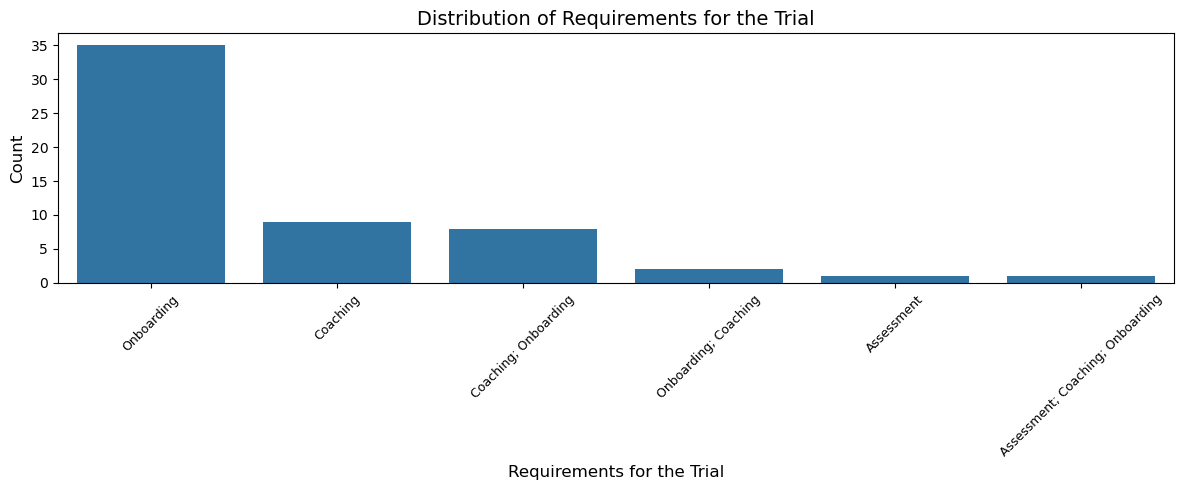

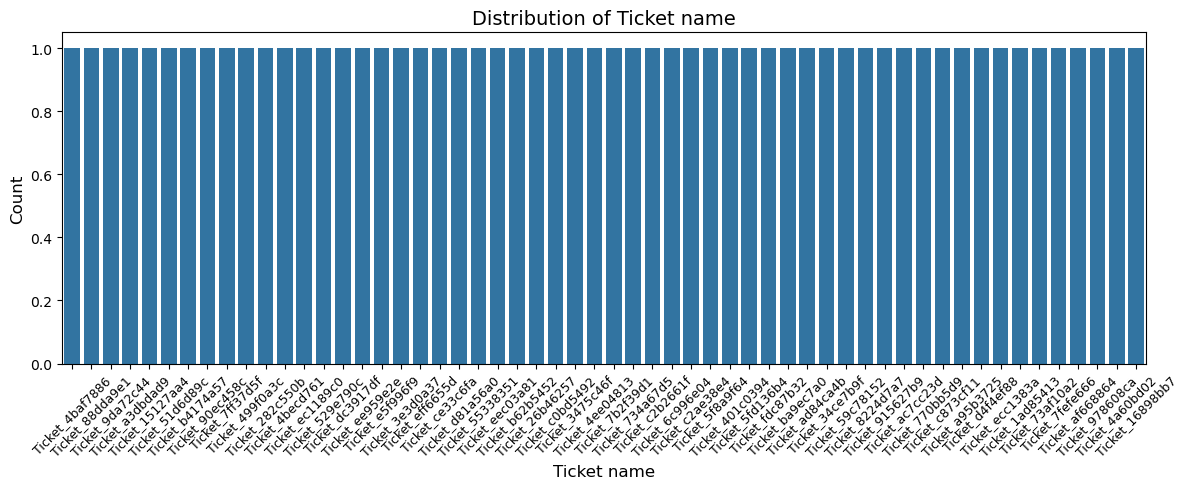

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_45181/508097811.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


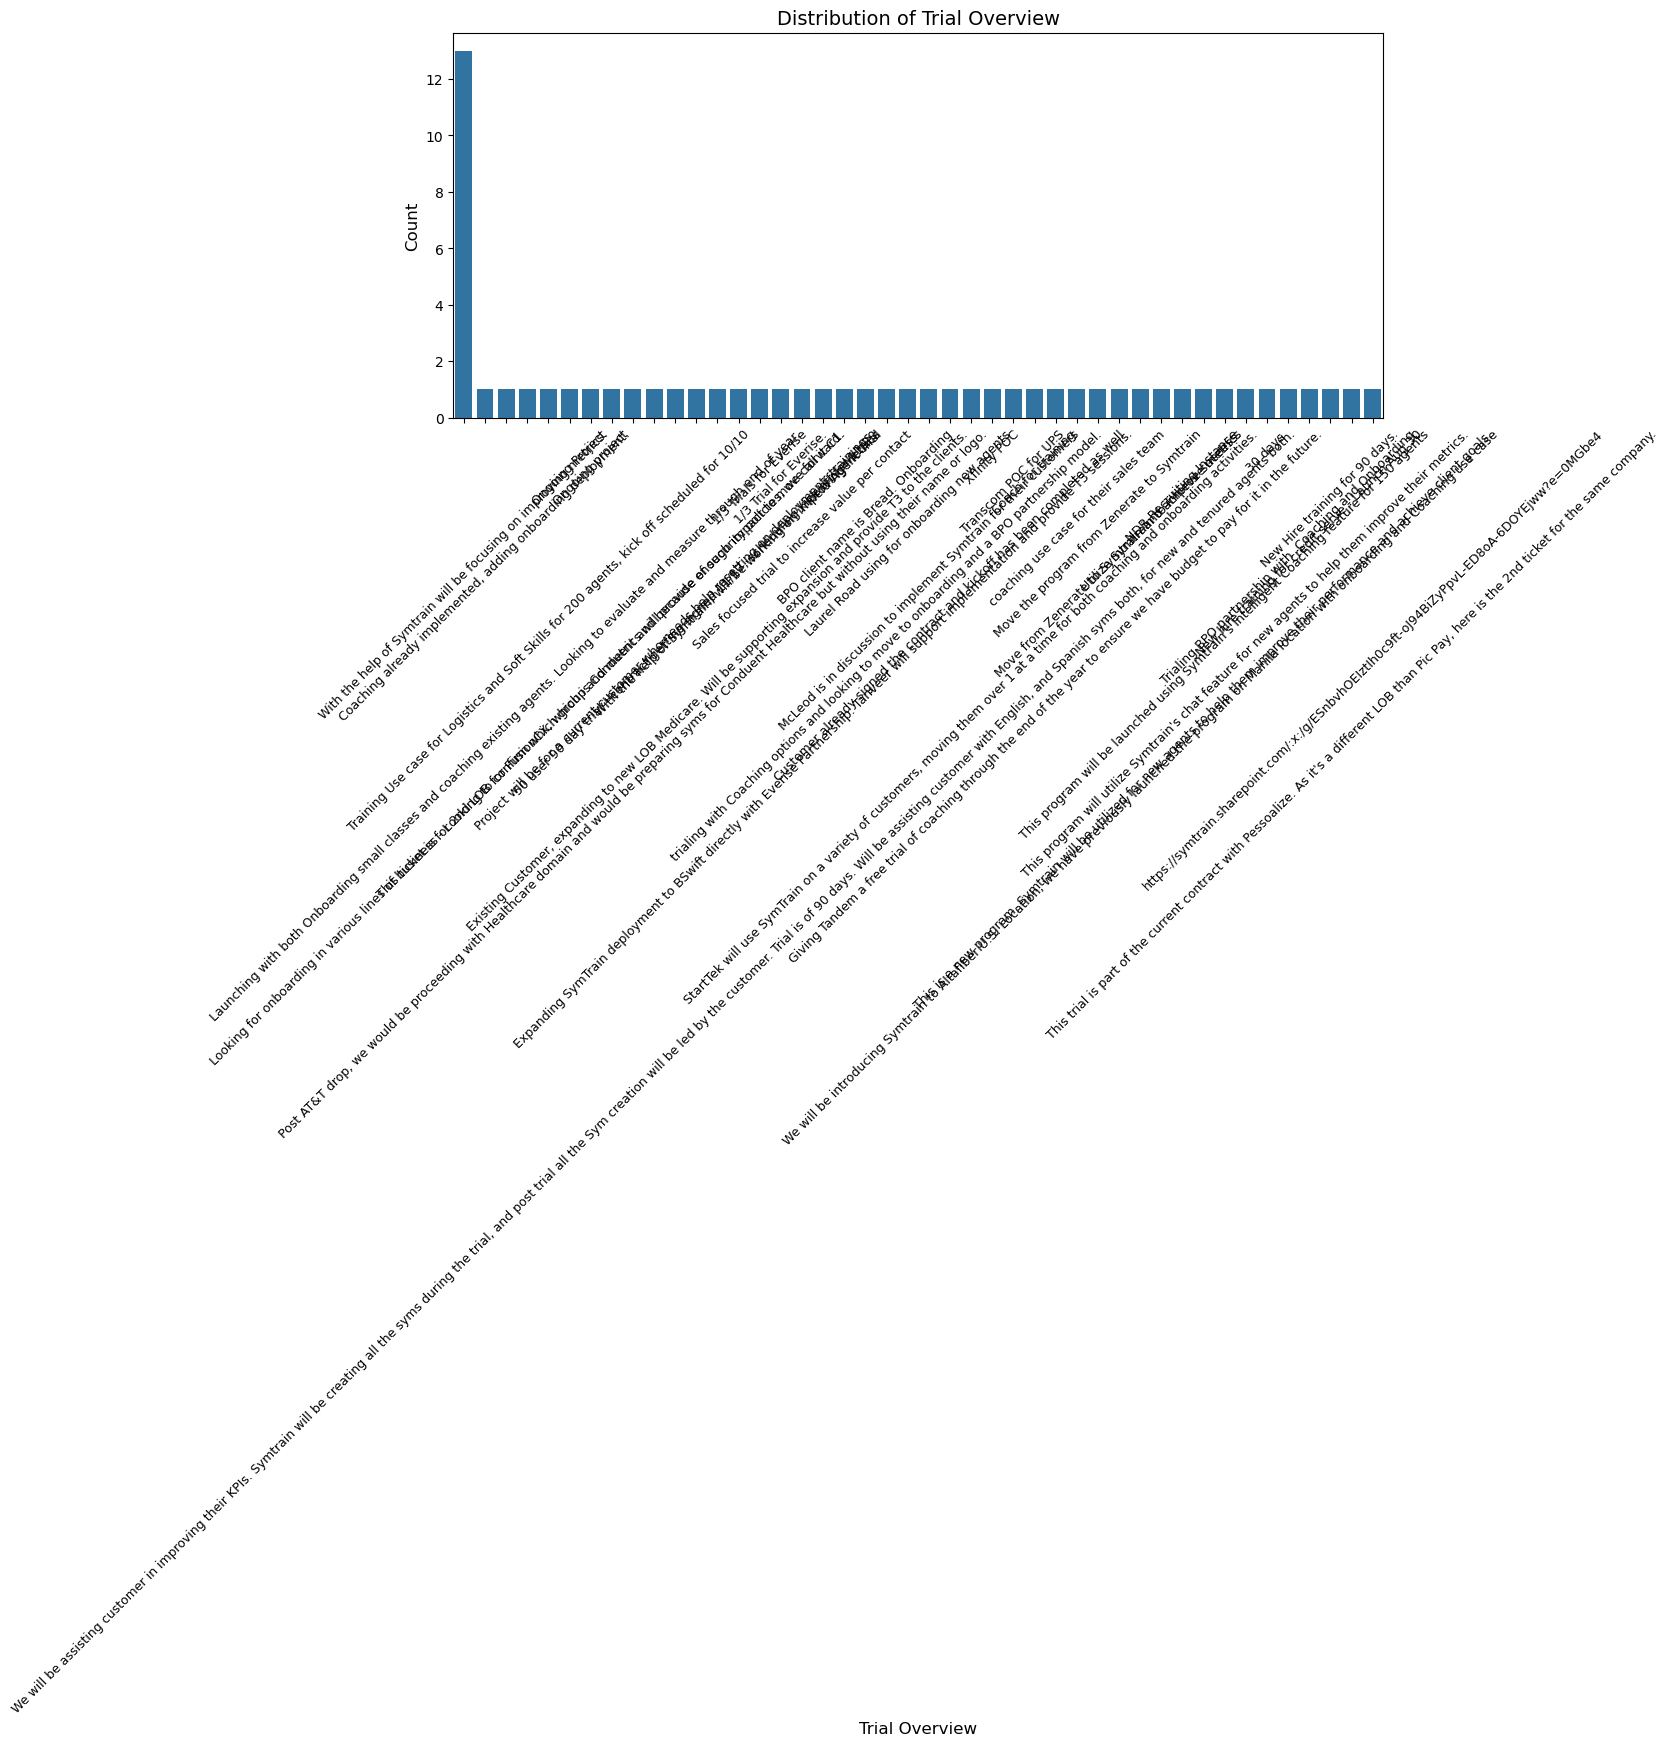

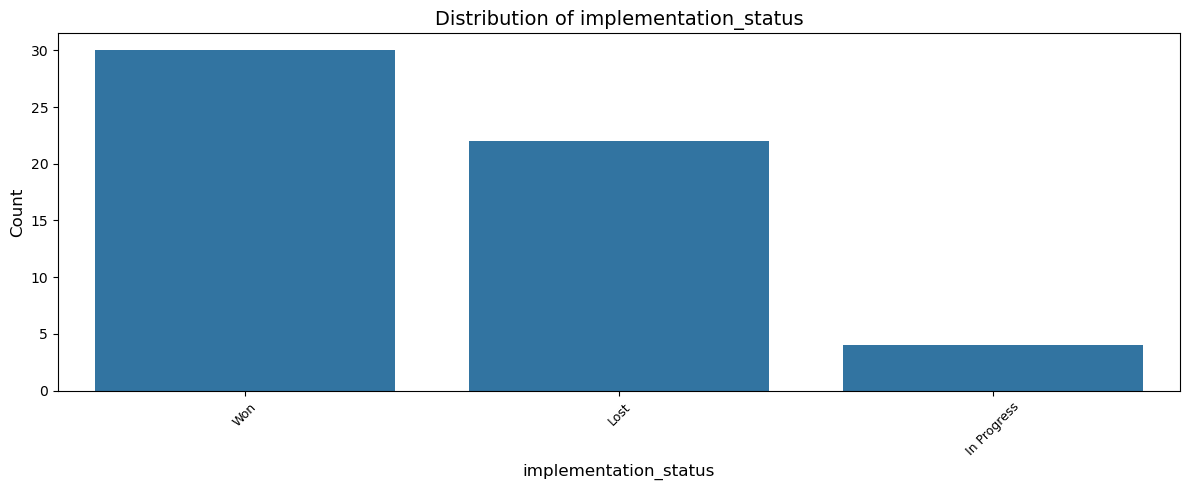

In [39]:
# Histograms for categorical variables 
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df_cleaned, x=col, order=df_cleaned[col].value_counts().index)
    plt.xticks(rotation=45, fontsize=9)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [49]:
num_columns

Index(['Time to first agent email reply (HH:mm:ss)',
       'Response time (HH:mm:ss)', 'Time to close (HH:mm:ss)',
       'implementation_duration_days', 'days_to_first_sym', 'create_year',
       'create_month'],
      dtype='object')

Failed to plot Time to first agent email reply (HH:mm:ss): Cannot cast ufunc 'equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'
Failed to plot Response time (HH:mm:ss): Cannot cast ufunc 'equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'
Failed to plot Time to close (HH:mm:ss): Cannot cast ufunc 'equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'


<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

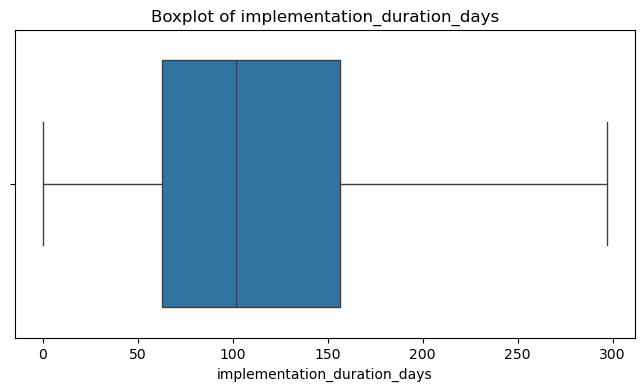

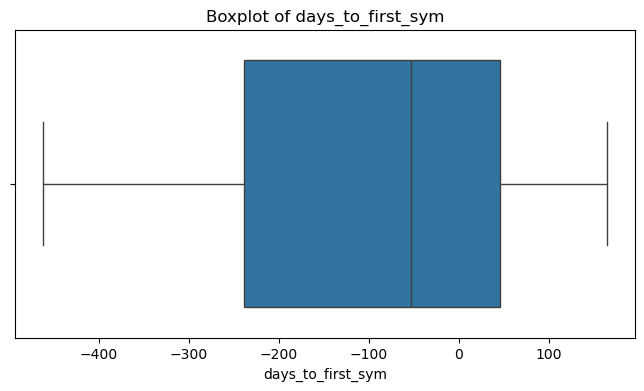

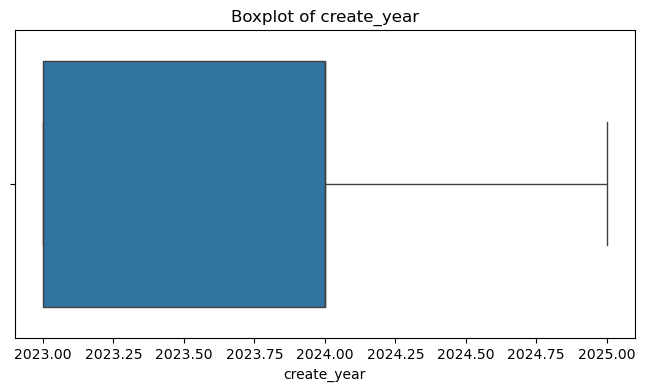

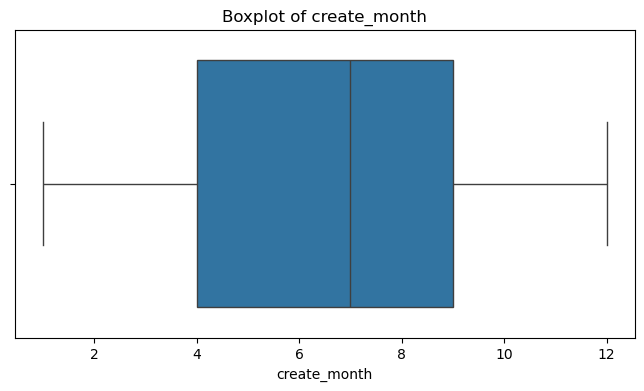

In [51]:
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
datetime_columns = df_cleaned.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
num_columns = [col for col in num_columns if col not in datetime_columns]

# Box plots
for col in num_columns:
    try:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_cleaned[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()
    except Exception as e:
        print(f"Failed to plot {col}: {e}")


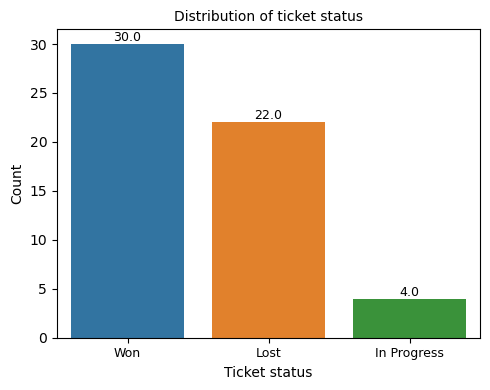

In [43]:
# Histograms for categorical variables 
plt.figure(figsize=(5, 4))
ax = sns.countplot(
    data=df_cleaned,
    x='implementation_status',
    order=df_cleaned["implementation_status"].value_counts().index,
    hue='implementation_status',
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.xticks(rotation=0, fontsize=9)
plt.title('Distribution of ticket status', fontsize=10)
plt.xlabel("Ticket status", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

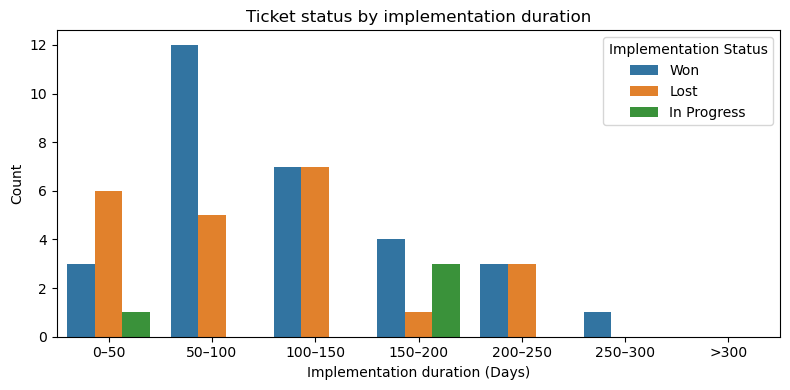

In [44]:
bin_width = 50
max_duration = df_cleaned['implementation_duration_days'].max()
bin_edges = list(range(0, int(np.ceil(max_duration / bin_width) * bin_width) + bin_width, bin_width))
bin_edges.append(np.inf)

labels = [f'{bin_edges[i]}–{bin_edges[i+1]}' for i in range(len(bin_edges) - 2)] + [f'>{bin_edges[-2]}']

df_cleaned['duration_group'] = pd.cut(
    df_cleaned['implementation_duration_days'],
    bins=bin_edges,
    labels=labels,
    include_lowest=True
)
plt.figure(figsize=(8, 4))
ax = sns.countplot(
    data=df_cleaned,
    x='duration_group',
    hue='implementation_status',
   # order=['Short (≤60d)', 'Moderate (61–90d)', 'Long (91–120d)', 'Very Long (>120d)']
)
plt.title('Ticket status by implementation duration')
plt.xlabel('Implementation duration (Days)')
plt.ylabel('Count')
plt.legend(title='Implementation Status', loc='upper right')
plt.tight_layout()
plt.show()


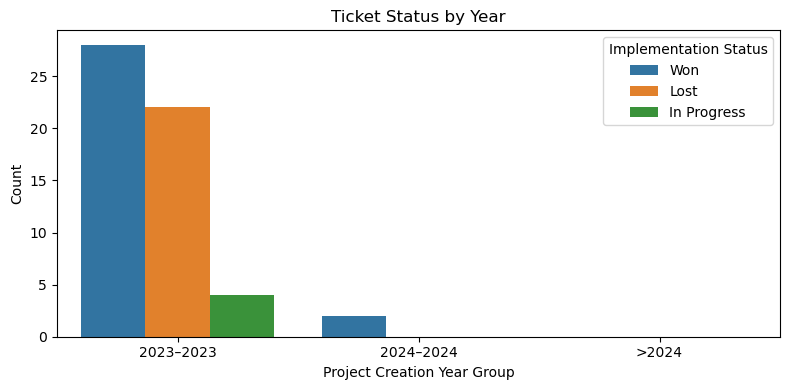

In [45]:
df_cleaned['create_year'] = df_cleaned['create_year'].astype(int)

bin_width = 1
max_year = df_cleaned['create_year'].max()
min_year = df_cleaned['create_year'].min()

bin_edges = list(range(min_year, max_year + bin_width, bin_width))
bin_edges.append(np.inf)  

labels = [f'{bin_edges[i]}–{bin_edges[i+1] - 1}' for i in range(len(bin_edges) - 2)] + [f'>{bin_edges[-2] - 1}']

df_cleaned['year_group'] = pd.cut(
    df_cleaned['create_year'],
    bins=bin_edges,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(8, 4))
ax = sns.countplot(
    data=df_cleaned,
    x='year_group',
    hue='implementation_status'
)
plt.title('Ticket Status by Year')
plt.xlabel('Project Creation Year Group')
plt.ylabel('Count')
plt.legend(title='Implementation Status', loc='upper right')
plt.tight_layout()
plt.show()

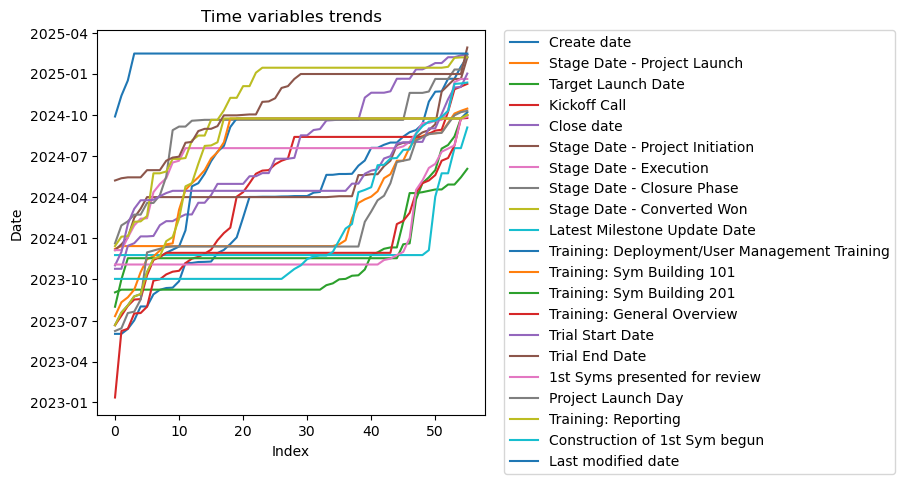

In [46]:
# Bar plots for time series data 
plt.figure(figsize=(5, 5))
for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col].dropna().sort_values().reset_index(drop=True).plot(label=col)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Index")
plt.ylabel("Date")
plt.title("Time variables trends")
plt.xticks(rotation=0)
plt.show()

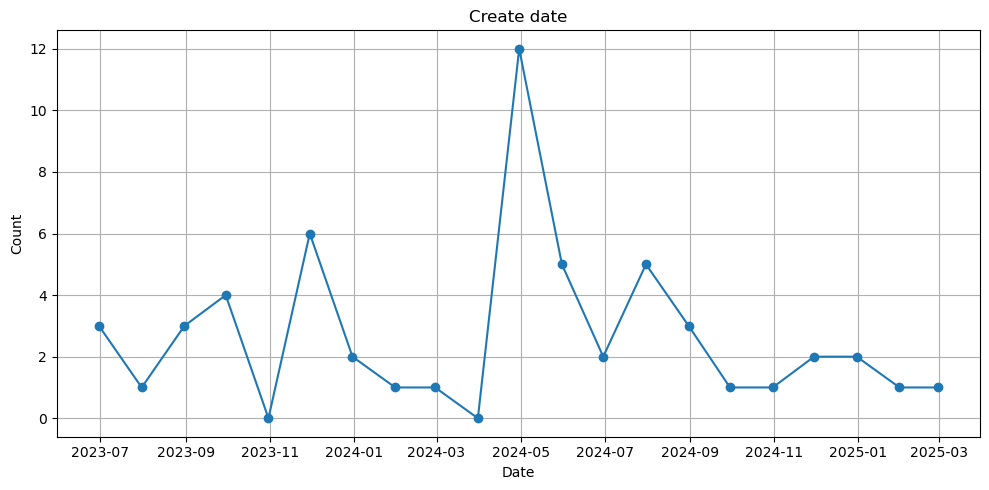

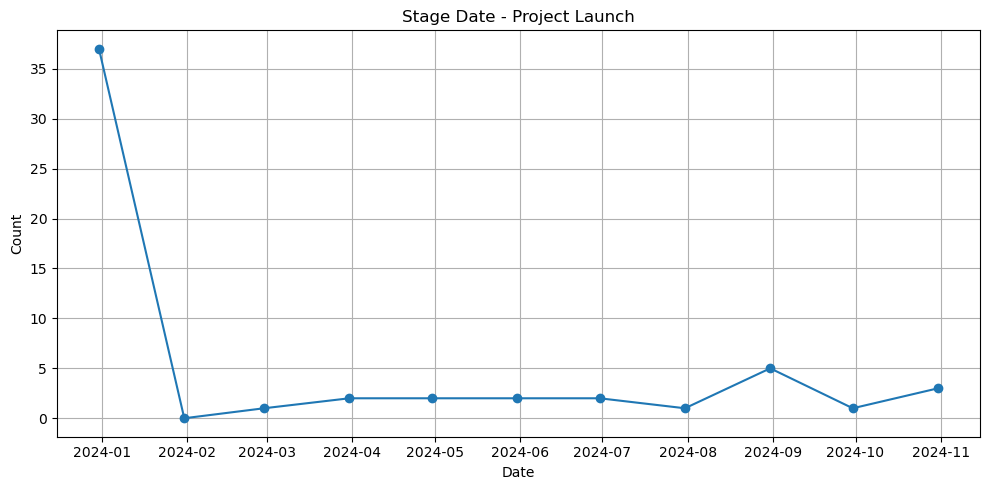

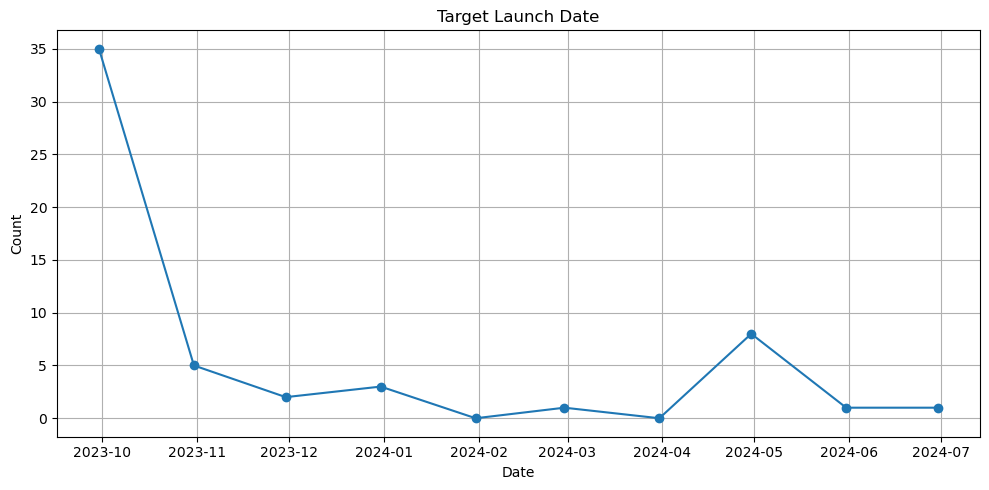

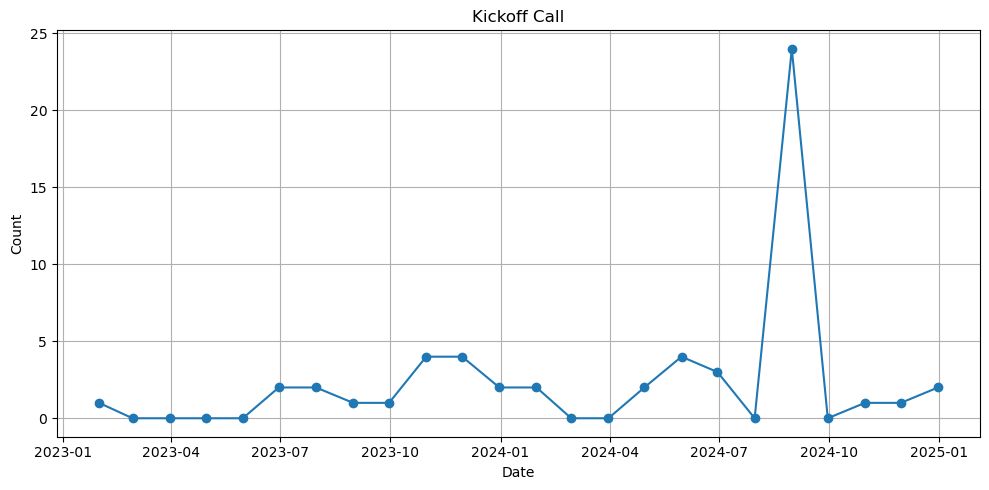

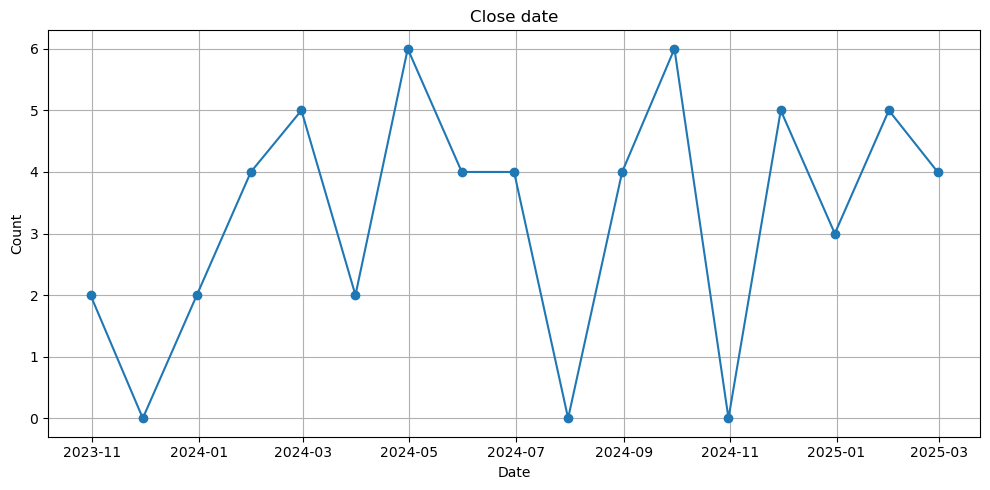

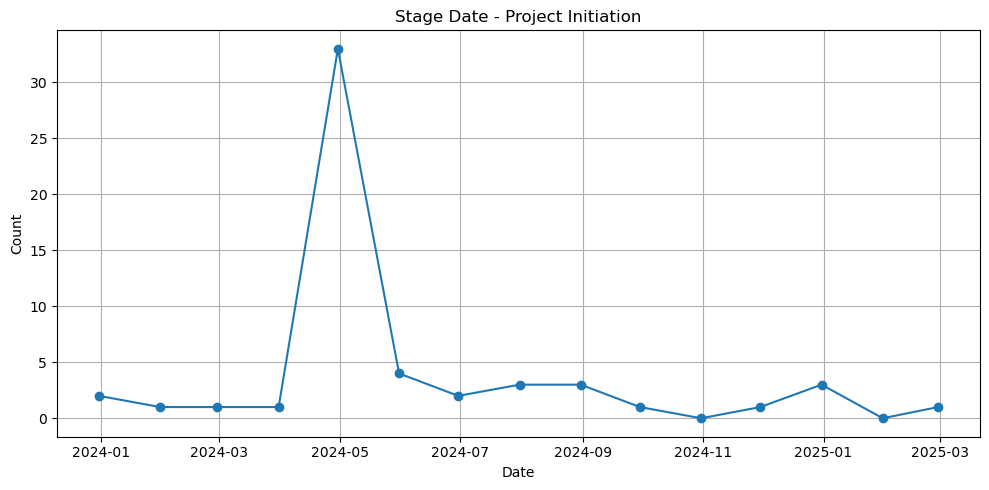

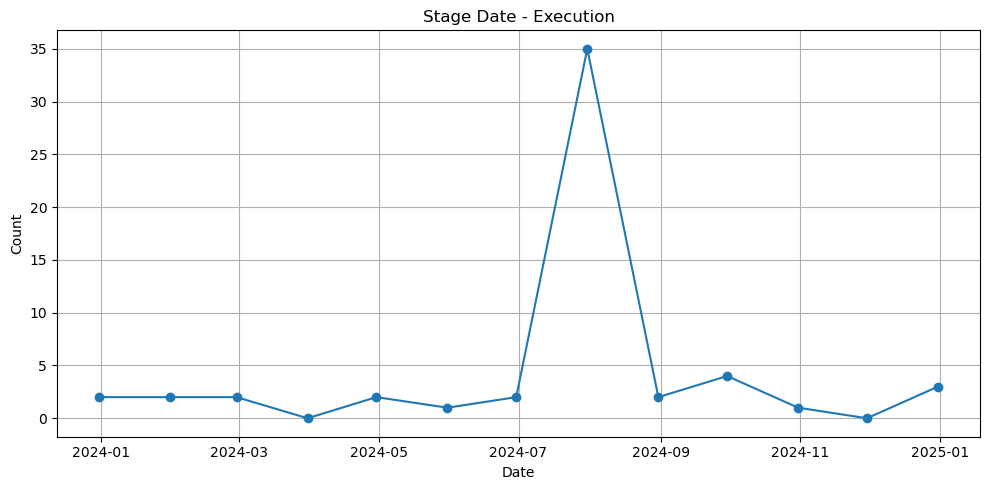

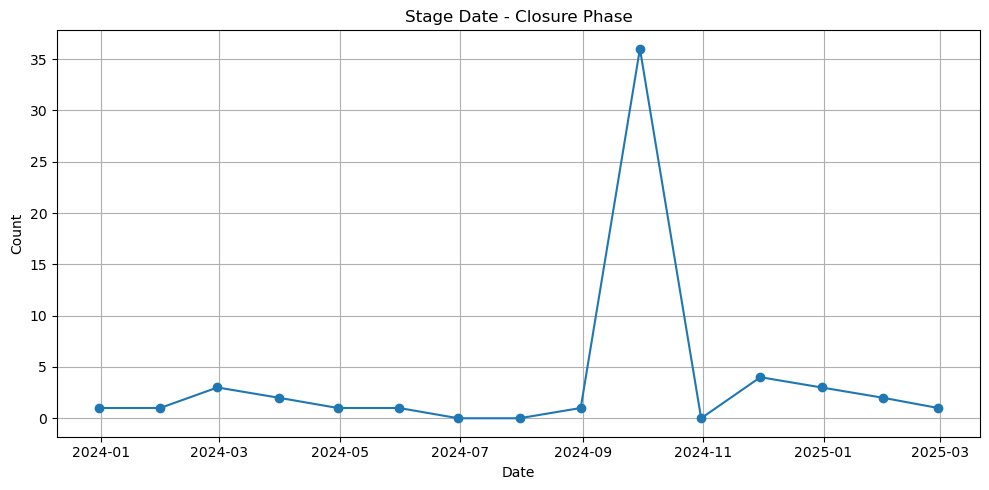

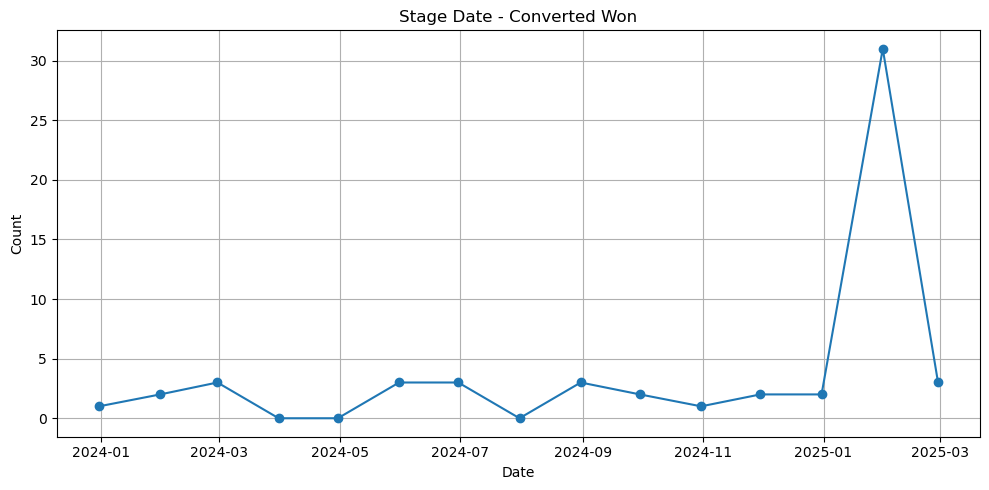

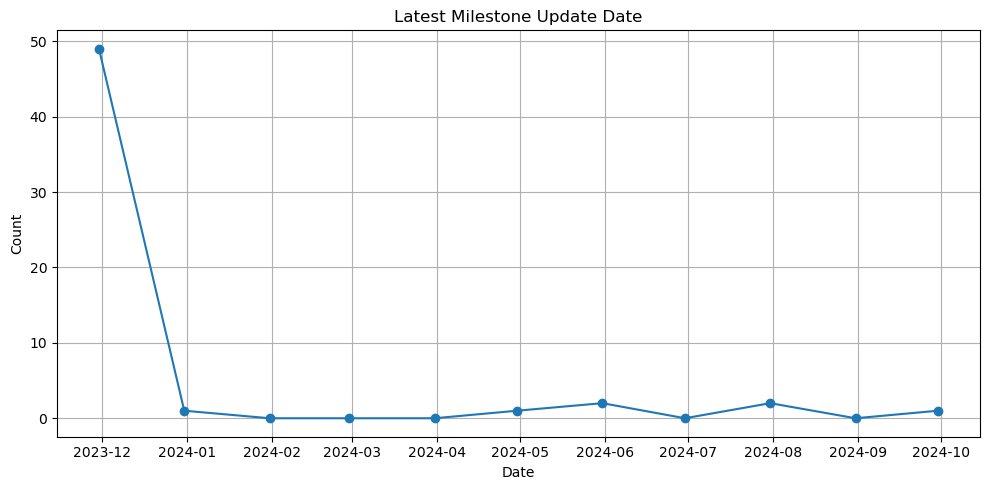

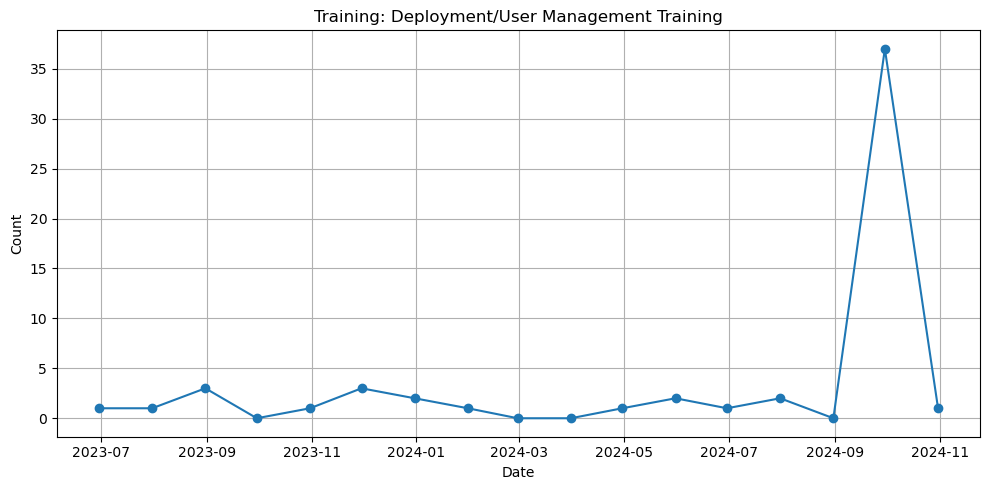

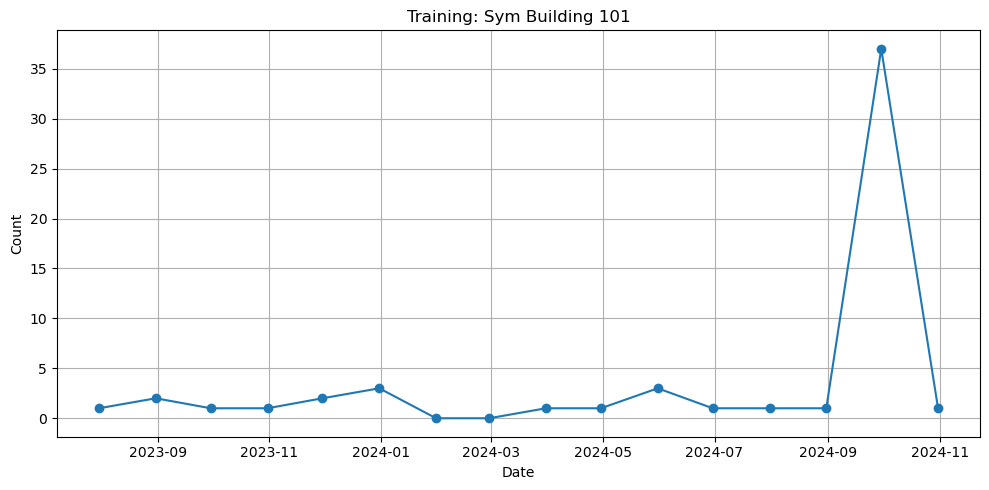

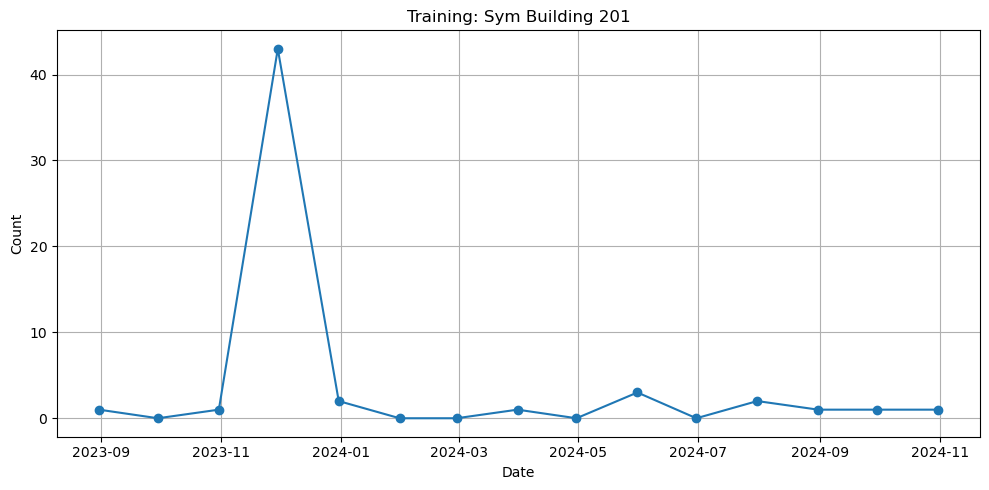

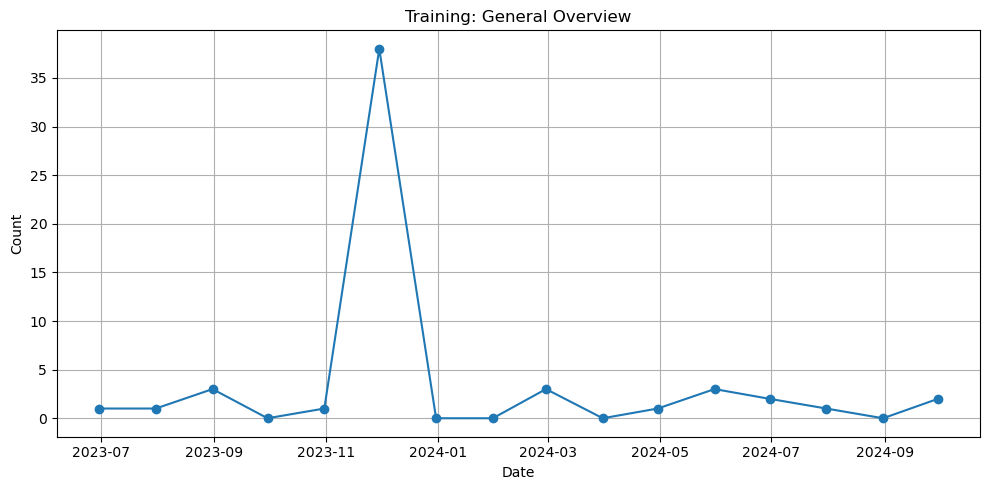

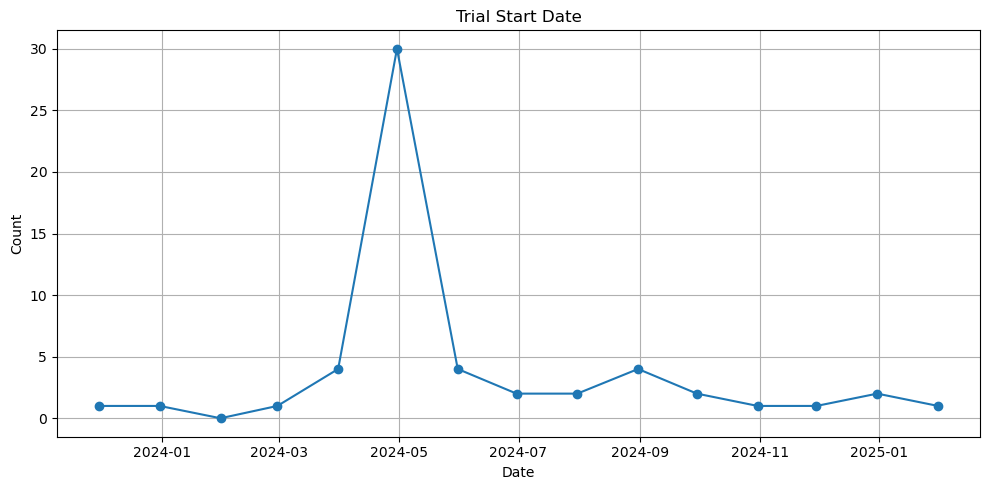

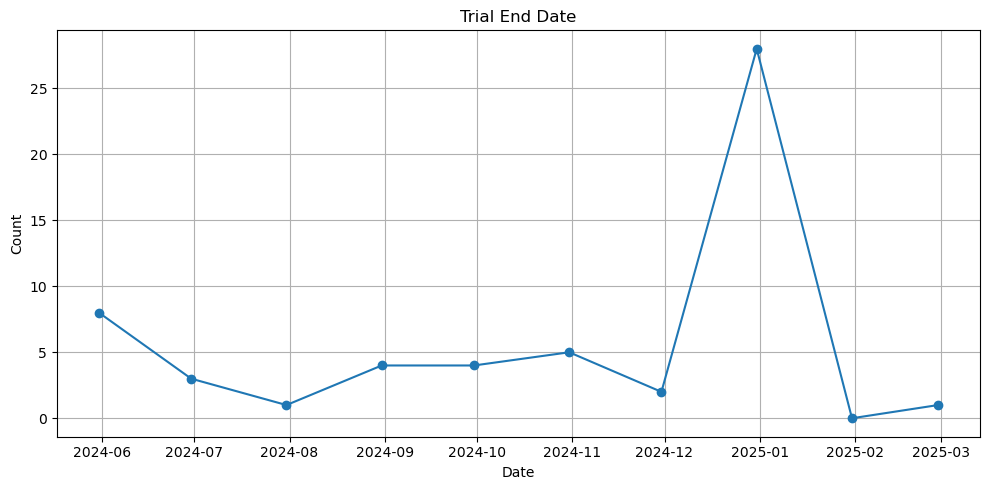

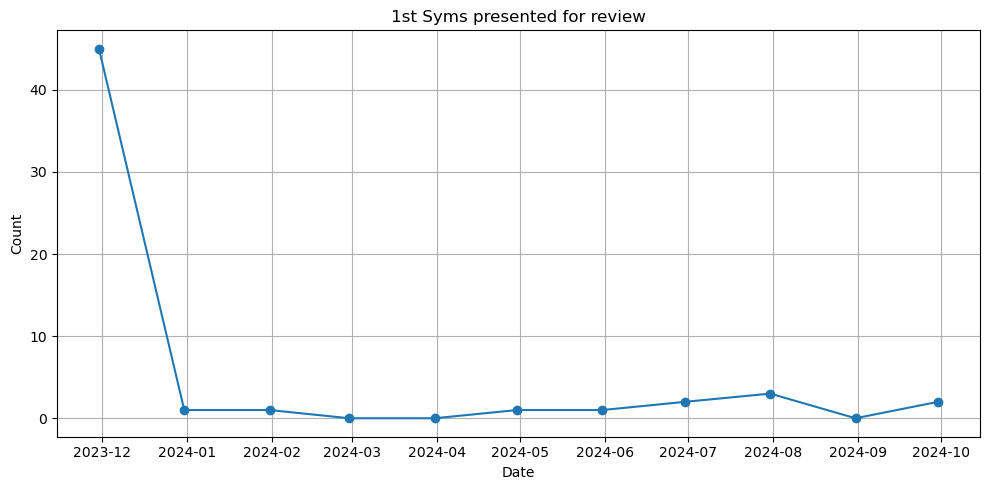

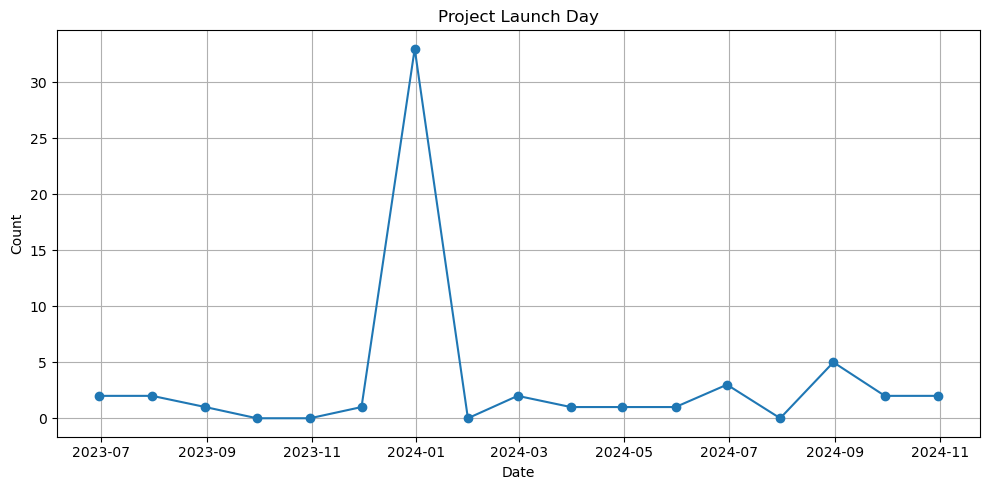

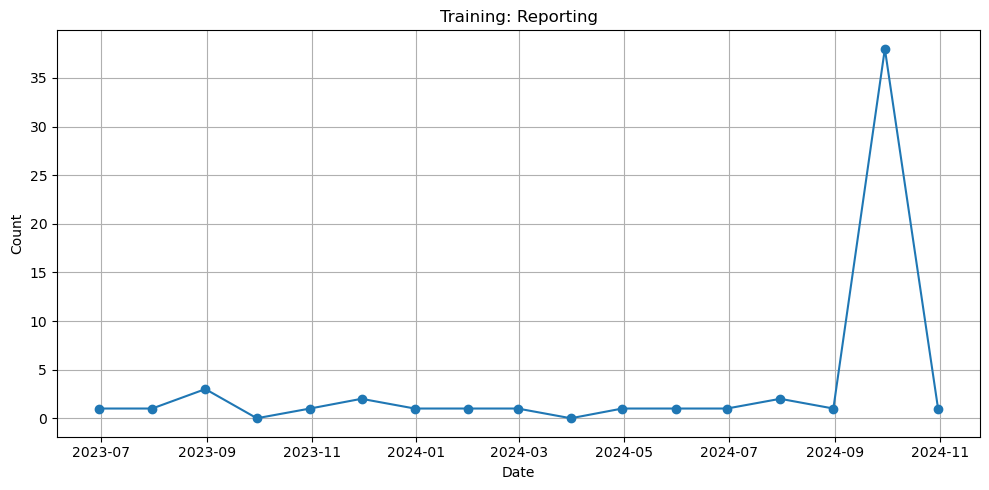

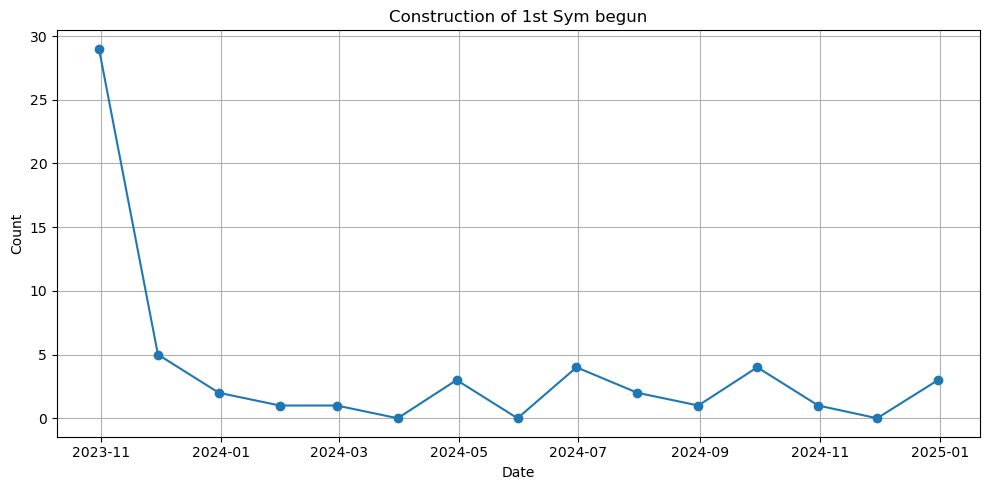

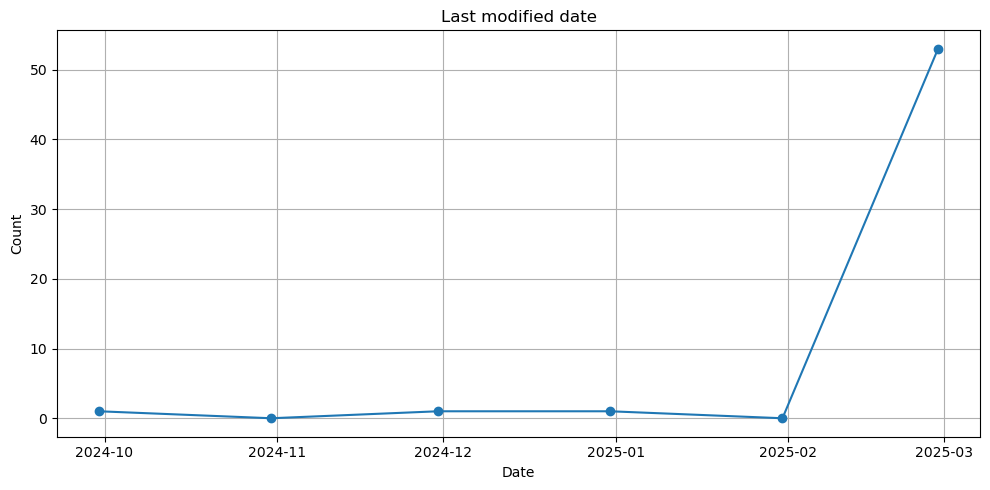

In [47]:
for col in date_cols:
    if col in df_cleaned.columns:
        company_count = df_cleaned.groupby(col).size()

        if not isinstance(company_count.index, pd.DatetimeIndex):
            company_count.index = pd.to_datetime(company_count.index, errors='coerce')
            company_count = company_count.dropna()  # Drop invalid dates

        company_count = company_count.resample('M').sum()

        plt.figure(figsize=(10, 5))
        plt.plot(company_count.index, company_count.values, marker='o')
        plt.xlabel("Date")
        plt.ylabel("Count")
        plt.title(f"{col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [48]:
df_cleaned.to_csv("cleaned_tickets.csv", index=False)